## Packages and Assets

In [35]:
from gensim.models import Word2Vec
import json
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
import seaborn as sns
import keras_tuner as kt
from keras.optimizers import SGD

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt
from keras.metrics import Accuracy, Precision, Recall
from keras.preprocessing.text import tokenizer_from_json
import os, sys


import keras.backend as K

In [36]:
print(sys.executable)
print(os.getcwd())

C:\Users\Guilherme\.conda\envs\nlp2\python.exe
C:\Users\Guilherme\Documents\Programming\Python\TCC_stock_price\pipeline\supervised_deep_models


## Dependencies

In [37]:
with open('../../assets/deep_assets/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)
    word_index = tokenizer.word_index



In [38]:
model_we = Word2Vec.load('../../assets/deep_assets/word2vec.model')

print(model_we.wv.most_similar('itau'))

# List of nparrays of size 300
embeddings_dict = {}
for word in model_we.wv.index_to_key:
    embeddings_dict[word] = model_we.wv[word]

embeddings_on_this_context = np.zeros((len(word_index), 300))
for word, i in word_index.items():
    embeddings_vector = embeddings_dict.get(word)
    if embeddings_vector is not None:
        embeddings_on_this_context[i - 1] = embeddings_vector


[('dia', 0.9978405833244324), ('acoes', 0.9978338479995728), ('petr4', 0.9978331327438354), ('ibovespa', 0.9978314638137817), ('gas', 0.9978266358375549), ('cento', 0.9978122711181641), ('carteira', 0.9978005886077881), ('<NUM>', 0.9977992177009583), ('petrobras', 0.9977961778640747), ('vai', 0.9977909326553345)]


In [39]:
train = pd.read_csv('../../assets/data/splits/train/padded.csv')
val = pd.read_csv('../../assets/data/splits/val/padded.csv')

## Functions

In [40]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text


def show_confusion_matrix(cm):
    print("Confusion Matrix")
    plt.figure(figsize=(10, 7))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title('Confusion Matrix')
    plt.show()

In [41]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## RNN Model

### Data transformation for model

In [42]:
X_train = train.to_numpy()[:, :-1]
X_val = val.to_numpy()[:, :-1]
y_train = train.to_numpy()[:, -1]
y_val = val.to_numpy()[:, -1]

### Tuning Architecture Hyperparams using RandomSearch and Early Stopping

#### Test 1

In [43]:
# def build_model(hp):
#     model = Sequential([
#         Embedding(input_dim=len(word_index), output_dim=300, input_length=X_train.shape[1], trainable=False,
#                   weights=[embeddings_on_this_context]),
#         Bidirectional(LSTM(16, return_sequences=True)),
#         Dropout(hp.Float('rate_dp_1', 0, 0.4, step=0.1)),
#         Bidirectional(LSTM(16)),
#         Dense(64, 'tanh'),
#         Dropout(hp.Float('rate_dp_1', 0.1, 0.4, step=0.1)),
#         Dense(4, activation='softmax')
#     ])
#     loss = "sparse_categorical_crossentropy"
#     # optimizer = SGD(learning_rate=0.01)
#     metrics = ['accuracy']
#
#     model.compile(loss=loss, optimizer='adam', metrics=metrics)
#     return model
#
#
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

####  Test 2

In [44]:
def build_model(hp):
    model = Sequential([
    Embedding(input_dim=len(word_index), output_dim= 300, input_length=X_train.shape[1], trainable=False, weights=[embeddings_on_this_context]),
    Bidirectional(LSTM(hp.Choice('units_bilstm_1',[16,32,64]), return_sequences=True)),
    Dropout(hp.Float('rate_dp_1',0,0.3,step=0.1)),
    Bidirectional(LSTM(hp.Choice('units_bilstm_2',[16,32,64]))),
    Dense(hp.Choice('units_dense',[16,32,64]), hp.Choice('activation',['tanh']) ),
    Dropout(hp.Float('rate_dp_2',0,0.3,step=0.1)),
    Dense(3, activation='softmax')
])
    loss = "sparse_categorical_crossentropy"
    # optimizer = SGD(learning_rate=0.01)
    metrics = ['accuracy']
    # metrics = ['accuracy', Precision(), Recall()]

    model.compile(loss=loss,optimizer='adam',metrics=metrics)
    return model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [45]:
# amanha testar dropout 0.0, 0.1, 0.2
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='../../assets/deep_assets',
    overwrite=True,
    project_name='lstm_tuning')

tuner.search_space_summary()

Search space summary
Default search space size: 6
units_bilstm_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
rate_dp_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
units_bilstm_2 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
units_dense (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh'], 'ordered': False}
rate_dp_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}


In [47]:
tuner.search(X_train, y_train, epochs=4000, validation_data=(X_val,y_val), callbacks=[es], batch_size=4, verbose=2)

Trial 10 Complete [00h 00m 28s]
val_accuracy: 0.5904762148857117

Best val_accuracy So Far: 0.5904762148857117
Total elapsed time: 00h 06m 32s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()
 # 0.845774233341217

In [ ]:
type(tuner.results_summary())

In [ ]:
with open('../../assets/deep_assets/tuner_results_10_attempts.txt', 'w') as f:
    f.write(str(tuner.results_summary()))


In [50]:
best_model_hp = tuner.get_best_hyperparameters()[0].values


#### Evaluation

### Tuning fit hyperparamters using GridSearch

In [ ]:
# model = Sequential([
#     Embedding(input_dim=len(word_index), output_dim= 300, input_length=X_train.shape[1], trainable=False, weights=[embeddings_on_this_context]),
#     Bidirectional(LSTM(64, return_sequences=True)),
#     # Dropout(0.29),
#     # Bidirectional(LSTM(hp.Choice('units',[32,64]))),
#     Bidirectional(LSTM(64)),
#     Dense(32, activation='relu'),
#     # Dropout(0.73),
#     Dense(4, activation='softmax')
# ])
#
# model.summary()
#
# from keras.optimizers import SGD
#
# loss = "sparse_categorical_crossentropy"
# optimizer = 'adam'
# metrics = ['accuracy']
#
# model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
#
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#
#
# history = model.fit(X_train, y_train, epochs=4000, validation_data=(X_val,y_val), verbose=2, callbacks=[es])


In [ ]:
# def architecture_tuned_model():
#     model = Sequential([
#         Embedding(input_dim=len(word_index), output_dim=300, input_length=X_train.shape[1], trainable=False,
#                   weights=[embeddings_on_this_context]),
#         Bidirectional(LSTM(32, return_sequences=True)),
#         Dropout(0.29),
#         Bidirectional(LSTM(16)),
#         Dense(64, 'tanh'),
#         Dropout(0.73),
#         Dense(4, activation='softmax')
#     ])
#     loss = "sparse_categorical_crossentropy"
#     optimizer = 'adam'
#     metrics = ['accuracy']
#
#     model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
#     return model


In [ ]:
# from keras.wrappers.scikit_learn import KerasClassifier
#
# model = KerasClassifier(build_fn=architecture_tuned_model, verbose=0)

In [ ]:
# from sklearn.model_selection import GridSearchCV
#
# es = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=5)
#
# param_grid = {'batch_size': [1,2,4,8]}
#
# gs = GridSearchCV(estimator=model,
#                   param_grid=param_grid,
#                   cv=5)
# gs.fit(X_train, y_train, callbacks=[es])
# print(f"Best results for {model.__class__.__name__}")
# print("Best Score of train set: " + str(gs.best_score_))
# print("Best estimator: " + str(gs.best_estimator_))
# print("Best parameter set: " + str(gs.best_params_))


In [ ]:
# gs.best_estimator_.model.history.history
# # 0.7766810655593872

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# ax1.plot(gs.best_estimator_.model.history.history['accuracy'])
# ax1.plot(gs.best_estimator_.model.history.history['loss'])
# ax1.set_title('Model Accuracy')
# ax1.set_ylabel('Accuracy')
# ax1.set_xlabel('Epoch')
# ax1.legend(['Train', 'Validation'], loc='upper left')
#
# ax2.plot(gs.best_estimator_.model.history.history['loss'])
# ax2.plot(gs.best_estimator_.model.history.history['val_loss'])
# ax2.set_title('Model Loss')
# ax2.set_ylabel('Loss')
# ax2.set_xlabel('Epoch')
# ax2.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# {'units_bilstm_1': 64,
#  'rate_dp_1': 0.1,
#  'units_bilstm_2': 32,
#  'units_dense': 32,
#  'activation': 'tanh',
#  'rate_dp_2': 0.0}

### Tuning fit hyperparameters manually

In [51]:
best_model = Sequential([
    Embedding(input_dim=len(word_index), output_dim= 300, input_length=X_train.shape[1], trainable=False, weights=[embeddings_on_this_context]),
    Bidirectional(LSTM(best_model_hp['units_bilstm_1'], return_sequences=True)),
    Dropout(best_model_hp['rate_dp_1']),
    # Bidirectional(LSTM(hp.Choice('units',[32,64]))),
    Bidirectional(LSTM(best_model_hp['units_bilstm_2'])),
    Dense(best_model_hp['units_dense'], activation=best_model_hp['activation']),
    # Dropout(0.73),
    Dense(3, activation='softmax')
])





loss = "sparse_categorical_crossentropy"
optimizer = 'adam'
metrics = ['accuracy']


best_model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)


best_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 300)            873300    
                                                                 
 bidirectional_2 (Bidirectio  (None, 8, 64)            85248     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 8, 64)             0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                

In [52]:
history = best_model.fit(X_train, y_train, epochs=4000, batch_size=1, validation_data=(X_val,y_val), verbose=2, callbacks=[es])

Epoch 1/4000
1676/1676 - 16s - loss: 0.9907 - accuracy: 0.5716 - val_loss: 0.9623 - val_accuracy: 0.5905 - 16s/epoch - 10ms/step
Epoch 2/4000
1676/1676 - 8s - loss: 0.9807 - accuracy: 0.5764 - val_loss: 0.9598 - val_accuracy: 0.5905 - 8s/epoch - 5ms/step
Epoch 3/4000
1676/1676 - 9s - loss: 0.9798 - accuracy: 0.5764 - val_loss: 0.9573 - val_accuracy: 0.5905 - 9s/epoch - 6ms/step
Epoch 4/4000
1676/1676 - 7s - loss: 0.9840 - accuracy: 0.5746 - val_loss: 0.9597 - val_accuracy: 0.5905 - 7s/epoch - 4ms/step
Epoch 5/4000
1676/1676 - 8s - loss: 0.9778 - accuracy: 0.5764 - val_loss: 0.9614 - val_accuracy: 0.5905 - 8s/epoch - 5ms/step
Epoch 6/4000
1676/1676 - 9s - loss: 0.9778 - accuracy: 0.5764 - val_loss: 0.9573 - val_accuracy: 0.5905 - 9s/epoch - 5ms/step
Epoch 7/4000
1676/1676 - 9s - loss: 0.9776 - accuracy: 0.5764 - val_loss: 0.9541 - val_accuracy: 0.5905 - 9s/epoch - 6ms/step
Epoch 8/4000
1676/1676 - 10s - loss: 0.9779 - accuracy: 0.5764 - val_loss: 0.9551 - val_accuracy: 0.5905 - 10s/epoc

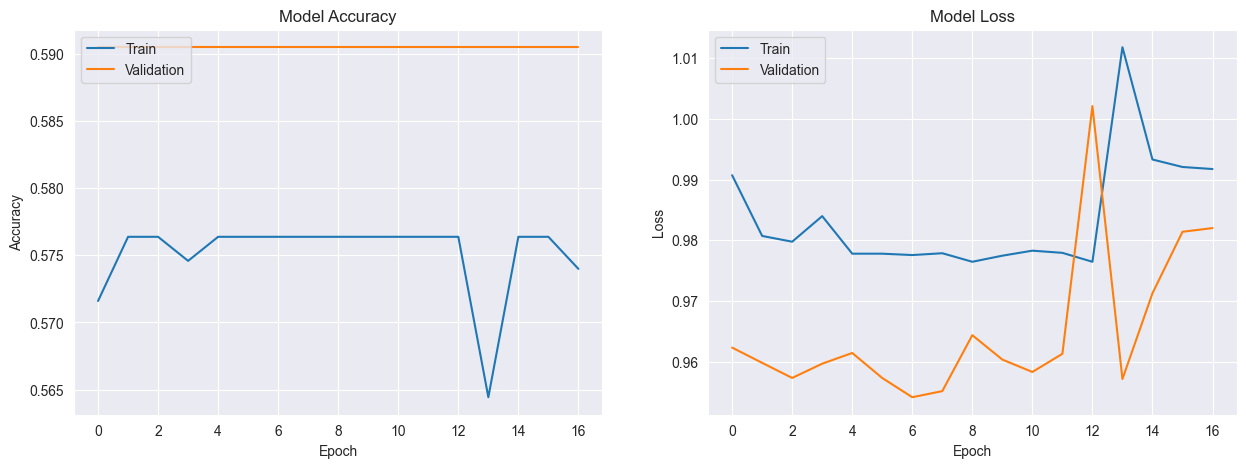

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Exporting model

In [ ]:
best_model.save('../../assets/deep_assets/lstm_model')